Asymmetrical conductor with a hole and coil with AC current
===
Problem 7 from https://www.compumag.org/wp/team/

In [273]:
%matplotlib widget

In [274]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw

In [275]:
# Al-plate settings
h_al = 19e-3
s_al = 293e-3 # side length
s_hole = 108e-3 # side length hole
d_hole = 18e-3 # distance from corner to hole

# z-distance plate to coil
d = 30e-3

# coil settings
r1 = 25e-3 # inner radius coil-bend
t_coil = 25e-3 # coil thickness in xy-plane
r2 = r1 + t_coil # outer radius coild-bend
a1 = 200e-3 # coil side length
a2 = a1 - 2*r2
x_coil = s_al-a1/2 # centre
y_coil = a1/2 # centre
z_coil = h_al + d # centre
h_coil = 100e-3 # coil thickness i z-direction
i_coil = a1/2 - t_coil # inner dimension of coil xy-plane
freq = 50 # Hz

In [276]:
p0 = (-1,-1,-1)
p1 = (1,1,1)
outer = Box(p0, p1).bc("outer")
outer.mat("air")

# The aluminium plate wiht hole
plate = Box(Pnt(0,0,0), Pnt(s_al,s_al,h_al)) - Box(Pnt(d_hole,d_hole,0), Pnt(d_hole+s_hole,d_hole+s_hole,h_al)) 
plate.maxh = 0.01
plate.mat("plate")

# The coil
coil = Cylinder(Pnt(0,0,z_coil), Z, r=r2, h=h_coil) - \
       Cylinder(Pnt(0,0,z_coil), Z, r=r1, h=h_coil)
box1 = Box(Pnt(0,0,z_coil+h_coil), Pnt(0+r2*1.1,0+r2*1.1,z_coil-h_coil))
c0 = coil * box1 # bend/corner
axis = Z
rot_axis = Axis((0,0,0), axis)
c1 = c0.Move(Vec(a2/2,a2/2,0))
c2 = c0.Move(Vec(a2/2,a2/2,0)).Rotate(rot_axis, 180)
c3 = c0.Move(Vec(a2/2,a2/2,0)).Rotate(rot_axis, 90)
c4 = c0.Move(Vec(a2/2,a2/2,0)).Rotate(rot_axis, 270)
coilbend = c1 + c2 + c3 + c4
coilbend = coilbend.Move(Vec(x_coil,y_coil,0))
coilbend.mat("coilbend")

b1 = Box(Pnt(i_coil,-(i_coil-r1),z_coil),Pnt(a1/2,(i_coil-r1),z_coil+h_coil))
b2 = b1.Rotate(rot_axis, 90).Move(Vec(x_coil,y_coil,0))
b3 = b1.Rotate(rot_axis, 180).Move(Vec(x_coil,y_coil,0))
b4 = b1.Rotate(rot_axis, 270).Move(Vec(x_coil,y_coil,0))
b1 = b1.Move(Vec(x_coil,y_coil,0))
b1.mat("b1")
b2.mat("b2")
b3.mat("b3")
b4.mat("b4")
#coil = coil_tmp.Move(Vec(x_coil,y_coil,0))
#coil.mat("coil")
#coil.maxh = 0.02

outer = outer - coilbend - b1 - b2 - b3 - b4 - plate

shape = Glue([coilbend, b1, b2, b3, b4, plate, outer]) # The full geometry glued 

solids = coilbend + b1 + b2 + b3 + b4 + plate
Draw(solids)
#Draw(shape)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3…

BaseWebGuiScene

In [277]:
mesh = OCCGeometry(shape).GenerateMesh(maxh=0.5) # assemble geometry and mesh with maximal mesh-size = maxh
#mesh.Refine()

# Select the boundary layer of the plate to be equal (or smaller) than the skindepth/3. 
# skindepth at 50 Hz: sqrt(2/(3e7*2*pi*50*4*pi*1e-7))/3
mesh.BoundaryLayer(".*", [0.003], material="plate", domains="plate") # add mesh layers in the plate

mesh.Curve(5) # improve mesh curvature with specified polynomial order

mesh = Mesh(mesh) # re-mesh

Draw (mesh, clipping = { "pnt" : (0,0,0), "vec" : (0,1,0) })

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [278]:
#fes = HCurl(mesh, order = 3, dirichlet="outer", nograds = False, complex = True) # Dirichlet on outer boundary
fes = HCurl(mesh, order = 3, nograds = False, complex = True) # Natural boundary condition used
print ("ndof =", fes.ndof)
u,v = fes.TnT()

import math
omega = 2*math.pi*freq
mur_list = {"plate": 1, "coilbend" : 1, "b1": 1, "b2": 1, "b3": 1, "b4": 1, "air" : 1 }
sigma_list = {"plate": 3.526e7, "coilbend": 1, "b1": 1, "b2": 1, "b3": 1, "b4": 1, "air": 0}
mu0 = 1.257e-6
nu_coef = [ 1/(mu0*mur_list[mat]) for mat in mesh.GetMaterials() ]
sigma_coef = [sigma_list[mat] for mat in mesh.GetMaterials() ]
eta_coef = [ -1j*omega*sigma_list[mat] for mat in mesh.GetMaterials() ]

sigma = CoefficientFunction(sigma_coef)
nu = CoefficientFunction(nu_coef)
eta = CoefficientFunction(eta_coef)
a = BilinearForm(fes, symmetric=False)
a += eta*u*v*dx + nu*curl(u)*curl(v)*dx + 1e-6*nu*u*v*dx # last term is for regularization

c = Preconditioner(a, type="bddc")

u = GridFunction(fes)

tau = CoefficientFunction(((y_coil-y), -(x_coil-x), 0)) # anti-clock-wise direction
tau = 1.0/Norm(tau)*tau
I0 = 2742
j = I0/(h_coil*t_coil) # Ampere/m^2 (+ for anticlockwise and - for clockwise direction)
f = LinearForm(fes)
f += SymbolicLFI(j*tau*v, definedon=mesh.Materials("coilbend")) 
f += SymbolicLFI(CoefficientFunction((0,j,0))*v, definedon=mesh.Materials("b1")) 
f += SymbolicLFI(CoefficientFunction((-j,0,0))*v, definedon=mesh.Materials("b2"))
f += SymbolicLFI(CoefficientFunction((0,-j,0))*v, definedon=mesh.Materials("b3")) 
f += SymbolicLFI(CoefficientFunction((j,0,0))*v, definedon=mesh.Materials("b4")) 

ndof = 1826500


In [279]:
with TaskManager():
    a.Assemble()
    f.Assemble()
    solver = CGSolver(mat=a.mat, pre=c.mat)
    u.vec.data = solver * f.vec
    #u.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

In [280]:
Draw (1e9*(curl(u).real), mesh, "B-field", draw_surf=False, \
      clipping = { "pnt" : (0,0,0), "vec" : (0,1,0), "function" : False }, autoscale=True, #, min=0, max=0.01,
      vectors = { "grid_size" : 100 }, order=3)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [281]:
# Compare current density in plate with the reference-TEAM7
import numpy as np
import matplotlib.pyplot as plt

def plot_j(ys, zs, xpts_ref, j_re_ref, j_im_ref):
    j_tot = 1j*2*math.pi*freq*mesh.MaterialCF(sigma_list,default=0)*u
    j_tot = 1j*omega*sigma*u
    j_re_tmp =  1e-6*j_tot.real # 1e-6*sigma*omega*u.real 
    j_im_tmp = 1e-6*j_tot.imag #1e-6*sigma*omega*u.imag #
    xpts_ngsolve = np.linspace(0,288,17*4)*1e-3
    j_re = np.array([j_re_tmp(mesh(xi,ys, zs)) for xi in xpts_ngsolve])
    j_im = np.array([j_im_tmp(mesh(xi,ys, zs)) for xi in xpts_ngsolve])    
         
    plt.figure(figsize=[12,5])
    #plt.subplot(1,2,1)
    plt.plot(1e3*xpts_ngsolve, j_re[:,1], '-o', label="Re NGSolve")
    plt.plot(1e3*xpts_ngsolve, j_im[:,1], '-o', label="Im NGSolve")
    plt.ylabel("Current Density [$10^6$ A/m$^2$]")
    plt.xlabel('Distance x, at y =' + str(ys1*1e3) + ", z = " + str(zs1*1e3) + " [mm]")
    plt.legend()
    #plt.subplot(1,2,1)
    plt.plot(1e3*xpts_ref, j_re_ref, '--+', label="Re Ref.")
    plt.plot(1e3*xpts_ref, j_im_ref, '--+', label="Im Ref.")
    plt.ylabel("Current Density [$10^6$ A/m$^2$]")
    plt.xlabel('Distance x, at y =' + str(ys1*1e3) + ", z = " + str(zs1*1e3) + " [mm]")
    plt.legend()
    plt.show()

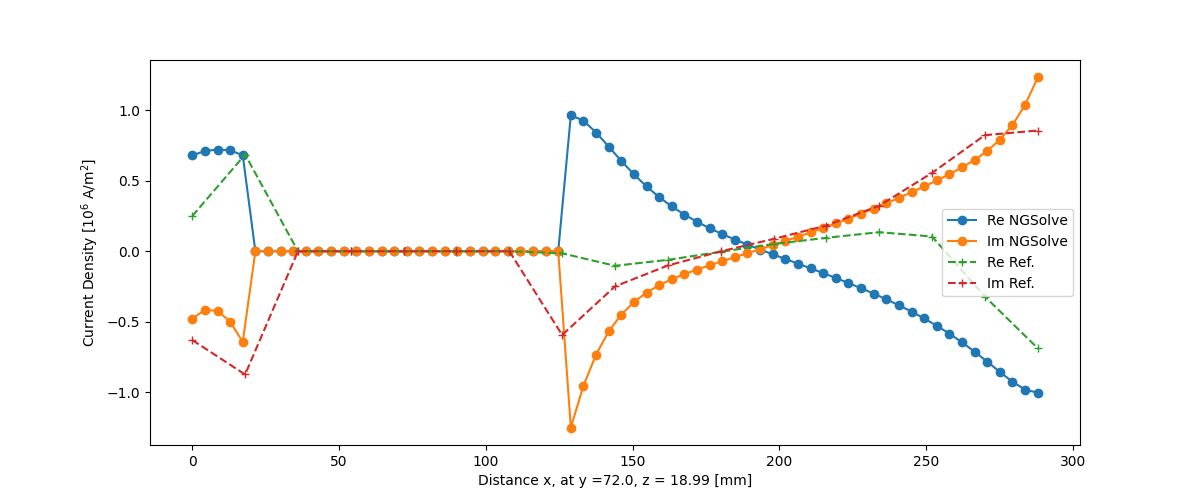

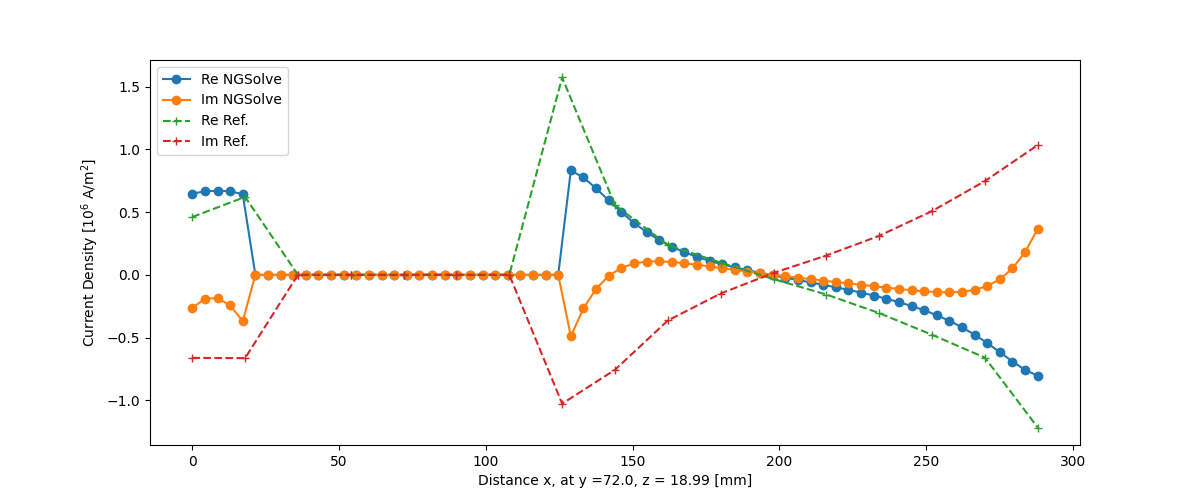

In [282]:
ys1 = 72e-3
zs1 = 18.99e-3
xpts_ref = np.linspace(0,288,17)*1e-3
jy_re_50Hz_ref1 = [0.249, 0.685, 0, 0, 0, 0, 0, -0.015, -0.103, -0.061, -0.004, 
                      0.051, 0.095, 0.135, 0.104, -0.321, -0.687]
jy_im_50Hz_ref1 = [-0.629, -0.873, 0, 0, 0, 0, 0, -0.593, -0.249, -0.101, -0.001, 
                  0.087, 0.182, 0.322, 0.555, 0.822, 0.855]
plot_j(ys1, zs1, xpts_ref, jy_re_50Hz_ref1, jy_im_50Hz_ref1)

ys2 = 72e-3
zs2 = 0.01e-3
xpts_ref = np.linspace(0,288,17)*1e-3
jy_re_50Hz_ref2 = [0.461, 0.621, 0, 0, 0, 0, 0, 1.573, 0.556, 0.237, 0.097, 
                      -0.034, -0.157, -0.305, -0.478, -0.660, -1.217]
jy_im_50Hz_ref2 = [-0.662, -0.664, 0, 0, 0, 0, 0, -1.027, -0.757, -0.364, -0.149, 
                  0.015, 0.154, 0.311, 0.508, 0.747, 1.034]
plot_j(ys2, zs2, xpts_ref, jy_re_50Hz_ref2, jy_im_50Hz_ref2)

In [285]:
# Compare magnetic flux density in plate with the reference-TEAM7
def plot_Bz(ys, zs, xpts_ref, B_re_ref, B_im_ref):

    B_re_tmp = 1e4*curl(u).real 
    B_im_tmp = 1e4*curl(u).imag 
    xpts = np.linspace(0,288,17*2-1)*1e-3
    B_re = np.array([B_re_tmp(mesh(xi,ys, zs)) for xi in xpts])
    B_im = np.array([B_im_tmp(mesh(xi,ys, zs)) for xi in xpts])    
    
    plt.figure(figsize = [12,5])
    plt.plot(1e3*xpts, B_re[:,2], '-o', label="Re NGSolve")
    plt.plot(1e3*xpts, B_im[:,2], '-o', label="Im NGSolve")
    plt.plot(1e3*xpts_ref, B_re_ref, '--+', label="Re Ref.")
    plt.plot(1e3*xpts_ref, B_im_ref, '--+', label="Im Ref.")
    plt.ylabel("Magnetic Flux Density [G]")
    plt.xlabel('Distance x, at y =' + str(ys*1e3) + ", z = " + str(zs*1e3) + " [mm]")
    plt.legend()
    plt.show()

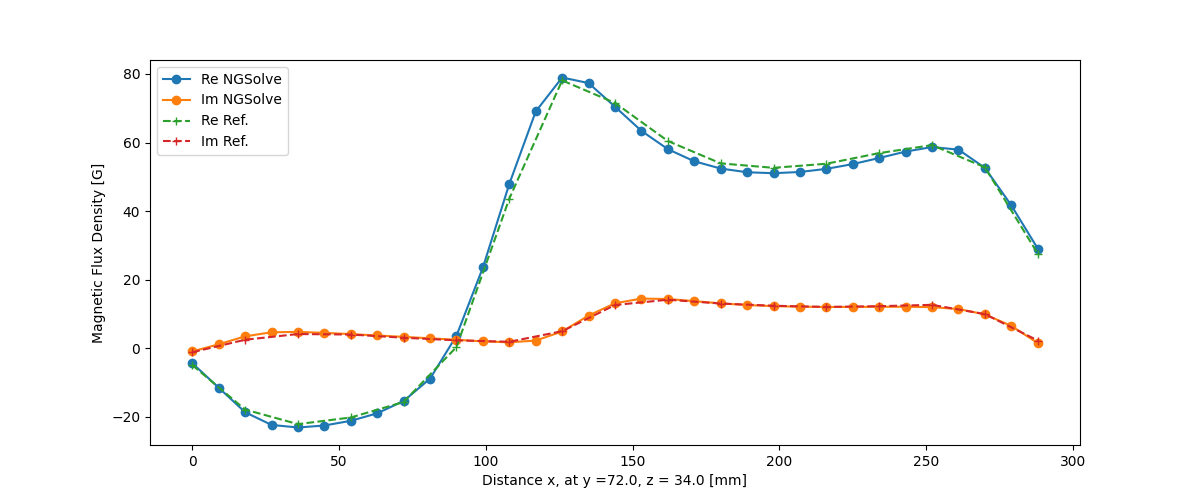

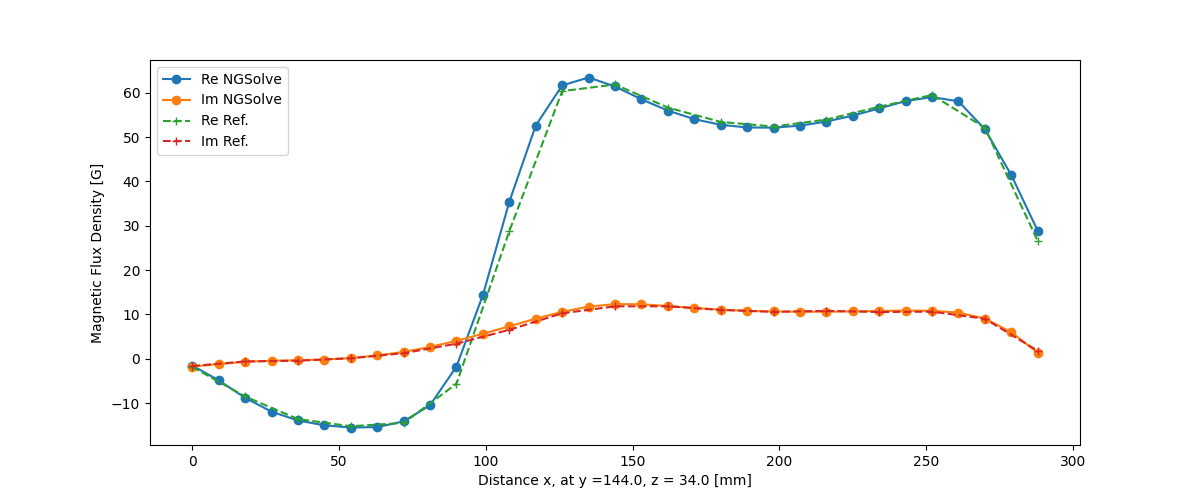

In [286]:
# Bz in Gauss (1e-4 Tesla) along line A1-B1 (y=72 mm, z=34 mm)
ys1 = 72e-3
zs1 = 34e-3
xpts_ref = np.linspace(0,288,17)*1e-3
Bz_re_50Hz_ref1 = [-4.9, -17.88, -22.13, -20.19, -15.67, 0.36, 43.64, 
                  78.11, 71.55, 60.44, 53.91, 52.62, 53.81, 56.91, 
                  59.24, 52.78, 27.61]
Bz_im_50Hz_ref1 = [-1.16, 2.48, 4.15, 4.00, 3.07, 2.31, 1.89, 4.97, 12.61,
                  14.15, 13.04, 12.40, 12.05, 12.27, 12.66, 9.96, 2.26]
plot_Bz(ys1, zs1, xpts_ref, Bz_re_50Hz_ref1, Bz_im_50Hz_ref1)

# Bz in Gauss (1e-4 Tesla) along line A1-B1 (y=144 mm, z=34 mm)
ys2 = 144e-3
zs2 = 34e-3
Bz_re_50Hz_ref2 = [-1.83, -8.50, -13.60, -15.21, -14.48, -5.62, 28.77, 
                  60.34, 61.84, 56.64, 53.40, 52.36, 53.93, 56.82, 
                  59.48, 52.08, 26.56]
Bz_im_50Hz_ref2 = [-1.63, -0.60, -0.43, 0.11, 1.26, 3.40, 6.53, 10.25, 11.83,
                  11.83, 11.01, 10.58, 10.80, 10.54, 10.62, 9.03, 1.79]
plot_Bz(ys2, zs2, xpts_ref, Bz_re_50Hz_ref2, Bz_im_50Hz_ref2)